In [1]:
![ -e navec_hudlit_v1_12B_500K_300d_100q.tar ] || wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar 

In [2]:
!pip install navec tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install slovnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd

import numpy as np
import sklearn

from tqdm import tqdm

In [5]:
from nltk.tokenize import WordPunctTokenizer
from gensim.models import Word2Vec

from navec import Navec

In [6]:
import torch
from slovnet.model.emb import NavecEmbedding

In [7]:
import re

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
def clear_text(text: str):
  bad_symbols = [",", "!", ":", "/", ".", "|", "(", ")", "-", "_", "?",";"]
  clear_text = ''

  for symbol in text:
    if symbol not in bad_symbols:
      clear_text += symbol
  return clear_text

In [10]:
def add_zero_indexes(ind, max_text_ind_len, pad_id):
    if len(ind) < max_text_ind_len:
        z_arr = np.full(max_text_ind_len, pad_id, np.int64)
        z_arr[:len(ind)] = ind
        ind = z_arr
    return ind

In [11]:
def bin2classes(x:int):
    return np.array([0,1]) if x == 1 else np.array([1,0])
def classes2bin(x):
    return 0 if x == [1,0] else 1

In [12]:
def get_text_indexes(words: str, word_model: Navec):
    indexes = []

    for word in words:
        try:
          indexes.append(word_model.vocab[word])
        except KeyError:
          indexes.append(word_model.vocab.unk_id)

    return np.array(indexes, dtype=np.int64)

In [13]:
model = Navec.load("navec_hudlit_v1_12B_500K_300d_100q.tar")

In [14]:
data_list = []
with open("dataset.txt") as file:
    for line in file:
        labels = line.split()[0]
        text = line[len(labels)+1:].strip()
        text = re.sub('[^a-zа-я]', ' ', text.lower())
        labels = labels.split(",")
        mask = [0 if "__label__NORMAL" in labels else 1]
        data_list.append((text, *mask))

In [15]:
#train_data = pd.read_csv("labeled.csv")
train_data = pd.DataFrame(data_list, columns=["comment", "toxic"])

In [16]:
tokenizer = WordPunctTokenizer()

In [17]:
train_data

,comment,toxic
0,скотина что сказать,1
1,я сегодня проезжала по рабочей и между домами ...,0
2,очередной лохотрон зачем придумывать очередно...,0
3,ретро дежавю сложно понять чужое сердце ...,0
4,а когда мы статус агрогородка получили,0
...,...,...
248285,правильно вс по пять,0
248286,банные нубы заходите на сервер мой ник creep...,1
248287,а у меня наверное рекорд в году в училище...,0
248288,спасибо всем большое,0


In [18]:
#train_data = train_data.sort_values(by=["comment"], key=lambda x: x.str.len())

In [19]:
train_data["comment"] = train_data["comment"].apply(lambda x: tokenizer.tokenize(x.lower()))

In [20]:
#train_data["toxic"] = train_data["toxic"].apply(lambda x: bin2classes(x))

In [21]:
train_data

,comment,toxic
0,"[скотина, что, сказать]",1
1,"[я, сегодня, проезжала, по, рабочей, и, между,...",0
2,"[очередной, лохотрон, зачем, придумывать, очер...",0
3,"[ретро, дежавю, сложно, понять, чужое, сердце,...",0
4,"[а, когда, мы, статус, агрогородка, получили]",0
...,...,...
248285,"[правильно, вс, по, пять]",0
248286,"[банные, нубы, заходите, на, сервер, мой, ник,...",1
248287,"[а, у, меня, наверное, рекорд, в, году, в, учи...",0
248288,"[спасибо, всем, большое]",0


In [22]:
train_data['indexed_text'] = train_data['comment'].apply(lambda x: get_text_indexes(x,model))

In [23]:
train_data.head()

,comment,toxic,indexed_text
0,"[скотина, что, сказать]",1,"[400498, 482066, 398293]"
1,"[я, сегодня, проезжала, по, рабочей, и, между,...",0,"[497765, 392196, 346615, 302187, 358548, 14647..."
2,"[очередной, лохотрон, зачем, придумывать, очер...",0,"[283911, 200367, 141519, 337022, 283911, 23006..."
3,"[ретро, дежавю, сложно, понять, чужое, сердце,...",0,"[376265, 103570, 403163, 320447, 482630, 39450..."
4,"[а, когда, мы, статус, агрогородка, получили]",0,"[14251, 173619, 223848, 418744, 500000, 318245]"


In [24]:
train_data['indexed_text_len'] = train_data['indexed_text'].apply(lambda x: len(x))

In [25]:
train_data

,comment,toxic,indexed_text,indexed_text_len
0,"[скотина, что, сказать]",1,"[400498, 482066, 398293]",3
1,"[я, сегодня, проезжала, по, рабочей, и, между,...",0,"[497765, 392196, 346615, 302187, 358548, 14647...",28
2,"[очередной, лохотрон, зачем, придумывать, очер...",0,"[283911, 200367, 141519, 337022, 283911, 23006...",54
3,"[ретро, дежавю, сложно, понять, чужое, сердце,...",0,"[376265, 103570, 403163, 320447, 482630, 39450...",10
4,"[а, когда, мы, статус, агрогородка, получили]",0,"[14251, 173619, 223848, 418744, 500000, 318245]",6
...,...,...,...,...
248285,"[правильно, вс, по, пять]",0,"[329214, 72080, 302187, 358229]",4
248286,"[банные, нубы, заходите, на, сервер, мой, ник,...",1,"[31148, 500000, 141214, 225007, 394252, 218719...",23
248287,"[а, у, меня, наверное, рекорд, в, году, в, учи...",0,"[14251, 445396, 212183, 225834, 375182, 51199,...",30
248288,"[спасибо, всем, большое]",0,"[413939, 72355, 44075]",3


In [26]:
train_data

,comment,toxic,indexed_text,indexed_text_len
0,"[скотина, что, сказать]",1,"[400498, 482066, 398293]",3
1,"[я, сегодня, проезжала, по, рабочей, и, между,...",0,"[497765, 392196, 346615, 302187, 358548, 14647...",28
2,"[очередной, лохотрон, зачем, придумывать, очер...",0,"[283911, 200367, 141519, 337022, 283911, 23006...",54
3,"[ретро, дежавю, сложно, понять, чужое, сердце,...",0,"[376265, 103570, 403163, 320447, 482630, 39450...",10
4,"[а, когда, мы, статус, агрогородка, получили]",0,"[14251, 173619, 223848, 418744, 500000, 318245]",6
...,...,...,...,...
248285,"[правильно, вс, по, пять]",0,"[329214, 72080, 302187, 358229]",4
248286,"[банные, нубы, заходите, на, сервер, мой, ник,...",1,"[31148, 500000, 141214, 225007, 394252, 218719...",23
248287,"[а, у, меня, наверное, рекорд, в, году, в, учи...",0,"[14251, 445396, 212183, 225834, 375182, 51199,...",30
248288,"[спасибо, всем, большое]",0,"[413939, 72355, 44075]",3


In [27]:
max_len = train_data['indexed_text_len'].max()
max_len

267

In [28]:
train_data = train_data[train_data.indexed_text_len <= 200]

In [29]:
train_data.groupby('toxic').sum()

,indexed_text_len
toxic,
0,2540831
1,601768


In [30]:
X = train_data['indexed_text'].to_list()

In [31]:
y = train_data["toxic"].to_list()

In [32]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.1, random_state=66)

In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")

In [34]:
class TextClassifierNN(torch.nn.Module):
    """
        Neural network model for the classification of text tonality
    """
    def __init__(self, embedding_dim: int, gru_hidden_size: int, fc_hidden_size: int, output_size: int, navec) -> None:
        """
        :param embedding_dim: embedding dim
        :param gru_hidden_size: gru hidden size
        :param fc_hidden_size: full connected hidden size
        :param output_size: output size
        :param navec: navec model
        """
        super(TextClassifierNN, self).__init__()

        self.relu = torch.nn.ReLU()

        self.softmax = torch.nn.Softmax(dim=-1)

        self.embedding = NavecEmbedding(navec)  # torch.nn.Embedding(input_size, embedding_dim)

        #weights = torch.FloatTensor(model.vectors)
        #self.embedding = torch.nn.Embedding.from_pretrained(weights)

        self.conv1 = torch.nn.Conv1d(embedding_dim, 512, kernel_size=(5,), padding=2)
        self.conv2 = torch.nn.Conv1d(512, 1024, kernel_size=(3,), padding=1)
        self.conv3 = torch.nn.Conv1d(1024, 2048, kernel_size=(5,), padding=2)

        self.gru = torch.nn.GRU(2048, gru_hidden_size, batch_first=True, num_layers=1)

        self.fc1 = torch.nn.Linear(gru_hidden_size, fc_hidden_size)
        
        self.fc2 = torch.nn.Linear(fc_hidden_size, output_size)


    def forward(self, x: torch.tensor) -> torch.tensor:
        x = self.embedding(x)

        x = x.permute((0, 2, 1))

        x = self.conv1(x)

        x = self.relu(x)

        x = self.conv2(x)

        x = self.relu(x)
        
        x = self.conv3(x)

        x = self.relu(x)

        x = x.permute((0, 2, 1))

        x, _ = self.gru(x)

        x, _ = x.max(dim=1)  # (batch_size, L, hidden_size)

        x = self.fc1(x)

        x = self.relu(x)
        
        x = self.fc2(x)

        return x

    def predict(self, x: torch.tensor) -> torch.tensor:
        return self.softmax(self.forward(x))

In [35]:
Net = TextClassifierNN(300, 512, 256, 2, model)
Net.to(device)

loss = torch.nn.CrossEntropyLoss()

/usr/local/lib/python3.7/dist-packages/slovnet/model/emb.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)
  torch.from_numpy(navec.pq.indexes),


In [36]:
optimizer = torch.optim.Adam(Net.parameters(), lr=1.0e-4)

In [37]:
test_loss_history = []
test_accuracy_history = []
test_precision_history = []
test_recall_history = []

In [38]:
def to_torch(data):
    return torch.nn.utils.rnn.pad_sequence([torch.from_numpy(x) for x in data], batch_first=True, padding_value=model.vocab.pad_id)

X_train = to_torch(X_train)
y_train = torch.as_tensor(y_train, dtype=torch.long)

X_test = to_torch(X_test)
y_test = torch.as_tensor(y_test, dtype=torch.long)

In [39]:
y_train

tensor([0, 0, 0,  ..., 0, 0, 1])

In [40]:
Net.train()

batch_size = 128*3
test_batch_size = 128*3

for epoch in range(5):
    order = np.random.permutation(len(X_train))
    torch.cuda.reset_peak_memory_stats()

    train_loss = 0.0
    train_accuracy = 0.0

    for start_index in tqdm(range(0, len(X_train), batch_size)):
        optimizer.zero_grad()

        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)

        preds = Net(X_batch) 
        loss_value = loss(preds, y_batch)

        train_loss += loss_value.item() * X_batch.shape[0]
        train_accuracy += (preds.argmax(dim=1) == y_batch).sum().item()

        loss_value.backward()
        optimizer.step()

    train_loss /= len(X_train)
    train_accuracy /= len(X_train)

    print(f'cuda memory {torch.cuda.memory_stats()["allocated_bytes.all.peak"] // (1024 * 1024)} MB')

    with torch.no_grad():
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()

        tp, fp, fn, loss_test_value = 0, 0, 0, 0

        for start_index in range(0, len(X_test), test_batch_size):

            batch_indexes = slice(start_index,start_index+test_batch_size)
            
            X_batch = X_test[batch_indexes].to(device)
            y_batch = y_test[batch_indexes].to(device)

            test_preds = Net(X_batch)

            loss_test_value += loss(test_preds, y_batch).item() * X_batch.shape[0]

            true_preds = test_preds.argmax(dim=1) == y_batch
            tp += torch.logical_and(true_preds, y_batch != 0).int().sum().item()
            fn += torch.logical_and(torch.logical_not(true_preds), y_batch != 0).int().sum().item()
            fp += torch.logical_and(torch.logical_not(true_preds), y_batch == 0).int().sum().item()

        tn = len(X_test) - tp - fp - fn

        precision = tp / max(tp + fp, 1)
        recall = tp / max(tp + fn, 1)
        accuracy = (tp + tn) / len(X_test)

        loss_test_value /= len(X_test)

        test_precision_history.append(precision)
        test_recall_history.append(recall)
        test_accuracy_history.append(accuracy)
        test_loss_history.append(loss_test_value)

        print(f"epoch {epoch+1}; train loss {train_loss}; train accuracy {train_accuracy}; test loss {loss_test_value}; test accuracy {accuracy}; test precision {precision}; test recall {recall}")
    print(f'cuda memory {torch.cuda.memory_stats()["allocated_bytes.all.peak"] // (1024 * 1024)} MB')
        
torch.save(Net.state_dict(),"TextTonalityClassifier.nn")

100%|██████████| 582/582 [15:07<00:00,  1.56s/it]


cuda memory 5494 MB
epoch 1; train loss 0.21296087288526394; train accuracy 0.9131742288294497; test loss 0.16171298537971537; test accuracy 0.934874541866366; test precision 0.8215405284370801; test recall 0.8173312541768768
cuda memory 2929 MB


100%|██████████| 582/582 [15:07<00:00,  1.56s/it]


cuda memory 5494 MB
epoch 2; train loss 0.14013083194350684; train accuracy 0.9427769747470454; test loss 0.13760552957394134; test accuracy 0.9453461677876677; test precision 0.9027777777777778; test recall 0.7819113388282468
cuda memory 2929 MB


100%|██████████| 582/582 [15:06<00:00,  1.56s/it]


cuda memory 5494 MB
epoch 3; train loss 0.12345948395022577; train accuracy 0.9500937532164737; test loss 0.1333488724896832; test accuracy 0.9463933303797978; test precision 0.9082213029989659; test recall 0.7825796391178437
cuda memory 2929 MB


100%|██████████| 582/582 [15:06<00:00,  1.56s/it]


cuda memory 5494 MB
epoch 4; train loss 0.11174556121136568; train accuracy 0.9543092916373921; test loss 0.13597163904233678; test accuracy 0.9454669942406058; test precision 0.8685633670350341; test recall 0.8229004232568501
cuda memory 2929 MB


100%|██████████| 582/582 [15:06<00:00,  1.56s/it]


cuda memory 5494 MB
epoch 5; train loss 0.10206760063193483; train accuracy 0.9582921251773256; test loss 0.135995701637163; test accuracy 0.9474807684562407; test precision 0.9174311926605505; test recall 0.7796836711962575
cuda memory 2929 MB


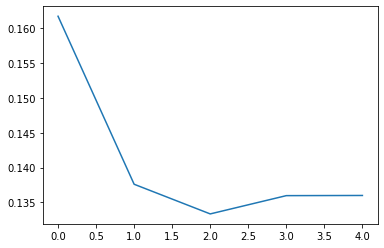

In [41]:
plt.plot(test_loss_history, label='loss')

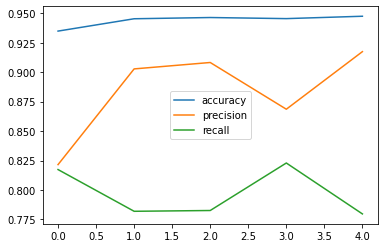

In [42]:
plt.plot(test_accuracy_history, label='accuracy')
plt.plot(test_precision_history, label='precision')
plt.plot(test_recall_history, label='recall')
plt.legend()
plt.show()  

In [43]:
Net.eval()
threshold = 0.7

with torch.no_grad():
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()

    tp, fp, fn, loss_test_value = 0, 0, 0, 0

    for start_index in range(0, len(X_test), test_batch_size):

        batch_indexes = slice(start_index,start_index+test_batch_size)
        
        X_batch = X_test[batch_indexes].to(device)
        y_batch = y_test[batch_indexes].to(device)

        test_preds = Net.predict(X_batch)

        true_preds = (test_preds[..., 1] >= threshold) == y_batch
        tp += torch.logical_and(true_preds, y_batch != 0).int().sum().item()
        fn += torch.logical_and(torch.logical_not(true_preds), y_batch != 0).int().sum().item()
        fp += torch.logical_and(torch.logical_not(true_preds), y_batch == 0).int().sum().item()

    tn = len(X_test) - tp - fp - fn

    precision = tp / max(tp + fp, 1)
    recall = tp / max(tp + fn, 1)
    accuracy = (tp + tn) / len(X_test)

    print(f"test accuracy {accuracy}; test precision {precision}; test recall {recall}")


test accuracy 0.9429699142132184; test precision 0.9574278058946115; test recall 0.7164179104477612


In [44]:
!nvidia-smi

Wed Jul 27 11:40:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    40W /  70W |   5288MiB / 15109MiB |     47%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------